In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten
from keras.layers import Layer, Reshape, BatchNormalization, Activation, Input
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.optimizers import RMSprop
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import random

Using TensorFlow backend.


In [0]:
latent_dim = 100
image_size = 28
image_shape = (image_size, image_size, 1)

gen_filters = [128, 64, 32, 1]
gen_strides = [2, 2, 1, 1]

dis_filters = [32, 64, 128, 256]
dis_strides = [2, 2, 2, 1]
kernel_size = 5
strides = 2
alpha = 0.2

batch_size = 64

dis_lr = 2e-4
dis_decay = 6e-8
dis_optimizer = RMSprop(lr=dis_lr, decay=dis_decay)

adv_lr = dis_lr * 0.5
adv_decay = dis_decay * 0.5
adv_optimizer = RMSprop(lr=adv_lr, decay=adv_decay)

save_intervals = 500
train_steps = 5000
log_print_steps = 200
test_size = 100

In [0]:
''' Load dataset '''
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.reshape((-1, image_size, image_size, 1)).astype('float32') / 255

os.makedirs('images', exist_ok=True)

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
def bn_relu(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [0]:
def build_generator(inputs, image_size=28):
    filters = gen_filters
    x = inputs

    image_resize = image_size // 4

    x = Dense(image_resize * image_resize * filters[0])(x)
    x = Reshape((image_resize, image_resize, filters[0]))(x)

    for strides, filter in zip(gen_strides, filters):
        x = bn_relu(x)
        x = Conv2DTranspose(filters=filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides=strides)(x)
    output = Activation('sigmoid', name='sigmoid')(x)
    model = Model(inputs, output, name='generator')
    # model.summary()
    plot_model(model, to_file='generator.png', show_shapes=True)
    return model

In [0]:
def build_discriminator(inputs):
    x = inputs
    for strides, filter in zip(dis_strides, dis_filters):
        x = LeakyReLU(alpha=alpha)(x)
        x = Conv2D(filters=filter,
                   kernel_size=kernel_size,
                   padding='same',
                   strides=strides)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    output = Activation('sigmoid', name='Sigmoid')(x)
    model = Model(inputs, output, name='discriminator')
    # model.summary()
    plot_model(model, to_file='discriminator.png', show_shapes=True)
    return model

In [0]:
def build_and_train():
    dis_inputs = Input(shape=image_shape, name='dis_inputs')
    dis = build_discriminator(dis_inputs)
    dis.compile(loss='binary_crossentropy',
                optimizer=dis_optimizer,
                metrics=['acc'])
    gen_inputs = Input(shape=(latent_dim,), name='gen_inputs')
    gen = build_generator(gen_inputs)

    dis.trainable = False
    adv_inputs = gen_inputs
    adv_outputs = dis(gen(gen_inputs))
    adv = Model(adv_inputs, adv_outputs, name='adverserial')
    adv.compile(loss='binary_crossentropy',
                optimizer = adv_optimizer,
                metrics=['acc'])
    # adv.summary()
    plot_model(adv, to_file='adverserial.png', show_shapes=True)
    models = gen, dis, adv
    history = train(models)
    return history

In [0]:
def train(models):
    m_train = x_train.shape[0]
    gen, dis, adv = models

    test_z = np.random.uniform(low=-1, high=1, size=[test_size, latent_dim])
    dis_loss = []
    dis_acc = []
    adv_loss = []
    adv_acc = []
    counter = 0
    for step in range(1, train_steps + 1):
        random_indices = np.random.randint(0, m_train, size=batch_size)
        real_images = x_train[random_indices]

        z = np.random.uniform(low=-1, high=1, size=[batch_size, latent_dim])
        fake_images = gen.predict(z)

        fake_labels = np.zeros((batch_size, 1))
        real_labels = np.ones((batch_size, 1))

        dis_x = np.concatenate([real_images, fake_images])
        dis_y = np.concatenate([real_labels, fake_labels])
        data = list(zip(dis_x, dis_y))
        random.shuffle(data)
        x_list = []
        y_list = []
        for x, y in data:
            x_list.append(x)
            y_list.append(y)
        dis_x = np.array(x_list)
        dis_y = np.array(y_list)
        
        loss_dis, acc_dis = dis.train_on_batch(dis_x, dis_y)
        log = f'epoch: {step} dis[loss:{loss_dis}, acc{acc_dis}]'

        adv_x = np.random.uniform(low=-1, high=1, size=[batch_size, latent_dim])
        adv_y = np.ones((batch_size, 1))

        loss_adv, acc_adv = adv.train_on_batch(adv_x, adv_y)
        log += f'adv[loss:{loss_adv}, acc{acc_adv}]'

        counter += 1
        if counter >= log_print_steps:
          counter = 0
          print(log)
        if step % save_intervals==0:
            plot_images(gen, test_z, step, show=False)
        ''' Get Loss and ACC '''
        dis_loss.append(loss_dis)
        dis_acc.append(acc_dis)
        adv_loss.append(loss_adv)
        adv_acc.append(acc_adv)
    history = dis_loss, dis_acc, adv_loss, adv_acc
    return history

In [0]:
def plot_images(generator, noise_input, step, show=False):
    image_address = '/content/drive/My Drive/images'
    z = noise_input
    n_images = z.shape[0]

    rows = np.sqrt(n_images)
    images = generator.predict(z)
    image_size = images.shape[1]

    for i in range(n_images):
        plt.subplot(rows, rows, i+1)
        plt.imshow(images[i].reshape((image_size, image_size)), cmap='gray')
        plt.axis('off')
    plt.savefig(os.path.join(image_address, f"{step}.png"))

    if show:
        plt.show()
    else:
        plt.close('all')

In [0]:
history = build_and_train()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where












/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 200 dis[loss:0.38333654403686523, acc0.875]adv[loss:1.265186071395874, acc0.15625]
epoch: 400 dis[loss:0.5602315068244934, acc0.734375]adv[loss:1.4717299938201904, acc0.078125]
epoch: 600 dis[loss:0.4754846692085266, acc0.7421875]adv[loss:0.9217338562011719, acc0.3125]
epoch: 800 dis[loss:0.4438804090023041, acc0.828125]adv[loss:1.4594922065734863, acc0.15625]
epoch: 1000 dis[loss:0.42511481046676636, acc0.78125]adv[loss:1.224022388458252, acc0.078125]
epoch: 1200 dis[loss:0.43501555919647217, acc0.78125]adv[loss:1.3966248035430908, acc0.046875]
epoch: 1400 dis[loss:0.4507688879966736, acc0.796875]adv[loss:1.0914583206176758, acc0.234375]
epoch: 1600 dis[loss:0.5317620038986206, acc0.71875]adv[loss:1.2157516479492188, acc0.25]
epoch: 1800 dis[loss:0.4488626718521118, acc0.8046875]adv[loss:1.241806149482727, acc0.0625]
epoch: 2000 dis[loss:0.4318975508213043, acc0.8203125]adv[loss:1.4065616130828857, acc0.078125]
epoch: 2200 dis[loss:0.49069368839263916, acc0.765625]adv[loss:1.73

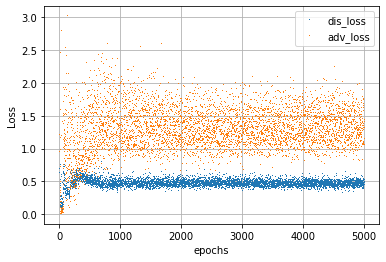

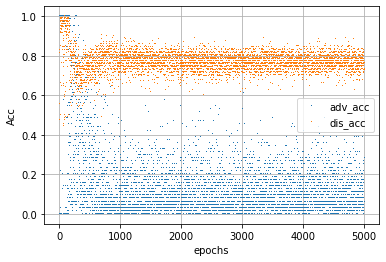

In [0]:
dis_loss, dis_acc, adv_loss, adv_acc = history

adv_loss = np.array(adv_loss)
dis_loss = np.array(dis_loss)
adv_acc = np.array(adv_acc)
dis_acc = np.array(dis_acc)

epochs = np.arange(train_steps)

''' Loss plot '''
plt.plot(epochs, dis_loss, ',', label='dis_loss')
plt.plot(epochs, adv_loss, ',', label='adv_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid('on')

''' Acc plot '''
plt.figure()
plt.plot(epochs, adv_acc, ',', label='adv_acc')
plt.plot(epochs, dis_acc, ',', label='dis_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.grid('on')